In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [4]:
def add_48hr_rolling(df):
    # Can't use np.roll b/c it does not deal with NANs
    # in a sophisticated manner.  Use np.nanmean which
    # skips all NANs and leaves them out of the sum and
    # division
    rolling = np.empty((0,), float)
    
    for i in range(len(df.index)):
        val = np.nanmean(df.loc[i-24:i+23, 'demand (MW)'])
        rolling = np.append(rolling, val)
    
    return df.assign(rolling48=rolling)

def add_48hr_rolling_iqr(df):
    rolling = np.empty((0,), float)
    
    for i in range(len(df.index)):
        lst = df.loc[i-24:i+23, 'demand (MW)']
        iqr = np.nanpercentile(lst, 75) - np.nanpercentile(lst, 25)
        rolling = np.append(rolling, iqr)
    
    return df.assign(rolling48iqr=rolling)

def add_48hr_rolling_median(df):
    rolling = np.empty((0,), float)
    
    for i in range(len(df.index)):
        val = np.nanmedian(df.loc[i-24:i+23, 'demand (MW)'])
        rolling = np.append(rolling, val)
    
    return df.assign(rolling48med=rolling)

def add_demand_delta_rolling(df):
    # Must have already called add_48hr_rolling
    diff = df['demand (MW)'] - df['rolling48']
    df = df.assign(dem_diff_rolling=diff)
    return df

# delta with previous and following time steps
def add_deltas(df):
    diff = df['demand (MW)'].diff()
    df = df.assign(diff_pre=diff)
    diff = df['demand (MW)'].diff(periods=-1)
    df = df.assign(diff_post=diff)
    return df


# Filter on a multiplier of the IQR and set
# the associated 'demand (MW)' value to NAN.
# Filter on 1 multiplier for double deltas
# and another for single jumps
def filter_deltas(df, iq2, iq3, iqr, m_double, m_single):
    for index, row in df.iterrows():
        if row['diff_pre'] > iq3 + iqr * m_single or row['diff_pre'] < iq2 - iqr * m_single:
            df.at[index, 'demand (MW)'] = np.nan
        elif row['diff_post'] > iq3 + iqr * m_single or row['diff_post'] < iq2 - iqr * m_single:
            df.at[index, 'demand (MW)'] = np.nan
        elif (row['diff_pre'] > iq3 + iqr * m_double or row['diff_pre'] < iq2 - iqr * m_double) and \
                (row['diff_post'] > iq3 + iqr * m_double or row['diff_post'] < iq2 - iqr * m_double):
            df.at[index, 'demand (MW)'] = np.nan
    return df


def filter_extrem_demand(df, iq2, iq3, multiplier):
    dem_iqr = iq3 - iq2
    df['demand (MW)'] = df['demand (MW)'].mask(df['demand (MW)'] > iq3 + dem_iqr * multiplier)
    return df

def mark_missing_and_empty(df, col):
    #marked = np.zeros(len(df.index))
    print(df[col].isna())

def show_structure(df):
    plt.imshow(~df.isna(), aspect='auto')
    plt.xlabel("variables")
    plt.ylabel("cases")
    plt.gray()
    plt.show()

def make_norm_diff_plot(df, iq2, iq3, factor, save):
    plt.close()
    fig, ax = plt.subplots()
    vals = (df['diff_pre']/df['rolling48iqr']).dropna()
    n, bins, patches = ax.hist(vals, 100, facecolor='red', alpha=0.2, label='pre')
    #n, bins, patches = ax.hist(df['diff_post'], 100, facecolor='blue', alpha=0.2, label='post')
    ax.set_xlabel('Normalized Demand Difference (MW)')
    ax.set_ylabel('Counts')
    
    # Draw iq2 and iq3
    iqr = iq3 - iq2
    iq2_l1 = mlines.Line2D([iq2,iq2], ax.get_ylim())
    ax.add_line(iq2_l1)
    iq2_l2 = mlines.Line2D([iq2-iqr*factor,iq2-iqr*factor], ax.get_ylim())
    ax.add_line(iq2_l2)
    iq3_l1 = mlines.Line2D([iq3,iq3], ax.get_ylim())
    ax.add_line(iq3_l1)
    iq3_l2 = mlines.Line2D([iq3+iqr*factor,iq3+iqr*factor], ax.get_ylim())
    ax.add_line(iq3_l2)
    
    plt.tight_layout()
    plt.yscale('log', nonposy='clip')
    plt.savefig(save)
    
def make_diff_plot(df, iq2, iq3, factor, save):
    plt.close()
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(df['diff_pre'], 100, facecolor='red', alpha=0.2, label='pre')
    #n, bins, patches = ax.hist(df['diff_post'], 100, facecolor='blue', alpha=0.2, label='post')
    ax.set_xlabel('Demand Difference (MW)')
    ax.set_ylabel('Counts')
        
    # Draw iq2 and iq3
    iqr = iq3 - iq2
    iq2_l1 = mlines.Line2D([iq2,iq2], ax.get_ylim())
    ax.add_line(iq2_l1)
    iq2_l2 = mlines.Line2D([iq2-iqr*factor,iq2-iqr*factor], ax.get_ylim())
    ax.add_line(iq2_l2)
    iq3_l1 = mlines.Line2D([iq3,iq3], ax.get_ylim())
    ax.add_line(iq3_l1)
    iq3_l2 = mlines.Line2D([iq3+iqr*factor,iq3+iqr*factor], ax.get_ylim())
    ax.add_line(iq3_l2)
    
    plt.tight_layout()
    plt.yscale('log', nonposy='clip')
    plt.savefig(save)

def make_dem_hist(df, iq2, iq3, factor, save, x_log=False):
    plt.close()
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(df['demand (MW)'], 100, facecolor='red', alpha=0.2, label='pre')
    #n, bins, patches = ax.hist(df['diff_post'], 100, facecolor='blue', alpha=0.2, label='post')
    ax.set_xlabel('Demand (MW)')
    ax.set_ylabel('Counts')
            
    # Draw iq2 and iq3
    iqr = iq3 - iq2
    iq2_l1 = mlines.Line2D([iq2,iq2], ax.get_ylim())
    ax.add_line(iq2_l1)
    iq2_l2 = mlines.Line2D([iq2-iqr*factor,iq2-iqr*factor], ax.get_ylim())
    ax.add_line(iq2_l2)
    iq3_l1 = mlines.Line2D([iq3,iq3], ax.get_ylim())
    ax.add_line(iq3_l1)
    iq3_l2 = mlines.Line2D([iq3+iqr*factor,iq3+iqr*factor], ax.get_ylim())
    ax.add_line(iq3_l2)
    
    if x_log:
        plt.xscale('log', nonposx='clip')
    plt.tight_layout()
    plt.yscale('log', nonposy='clip')
    plt.savefig(save)

    
def make_delta_dem_hist(df, save):
    plt.close()
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(df['dem_diff_rolling'], 100, facecolor='red', alpha=0.2, label='pre')
    ax.set_xlabel('$\Delta$(Demand, 48hr Avg) (MW)')
    ax.set_ylabel('Counts')
    plt.tight_layout()
    plt.yscale('log', nonposy='clip')
    plt.savefig(save)

def get_iqrs(vals):
    iq3 = np.nanpercentile(vals, 75)
    iq2 = np.nanpercentile(vals, 25)
    iqr = iq3 - iq2
    return iqr, iq2, iq3

def return_all_regions():
    return ['AEC', 'AECI', 'CPLE', 'CPLW',
    'DUK', 'FMPP', 'FPC',
    'FPL', 'GVL', 'HST', 'ISNE',
    'JEA', 'LGEE', 'MISO', 'NSB',
    'NYIS', 'OVEC', 'PJM', 'SC',
    'SCEG', 'SEC', 'SOCO',
    'SPA', 'SWPP', 'TAL', 'TEC',
    'TVA', 'ERCO',
    'AVA', 'AZPS', 'BANC', 'BPAT',
    'CHPD', 'CISO', 'DOPD',
    'EPE', 'GCPD', 'IID',
    'IPCO', 'LDWP', 'NEVP', 'NWMT',
    'PACE', 'PACW', 'PGE', 'PNM',
    'PSCO', 'PSEI', 'SCL', 'SRP',
    'TEPC', 'TIDC', 'TPWR', 'WACM',
    'WALC', 'WAUW']

TIDC
iqr pre 16.00 x 5 = 80.00
diff_pre 25% -8.00  75% 8.00


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


CISO
iqr pre 1428.00 x 5 = 7140.00
diff_pre 25% -679.00  75% 749.00
LDWP
iqr pre 222.00 x 5 = 1110.00
diff_pre 25% -111.00  75% 111.00
BANC
iqr pre 129.00 x 5 = 645.00
diff_pre 25% -61.00  75% 68.00


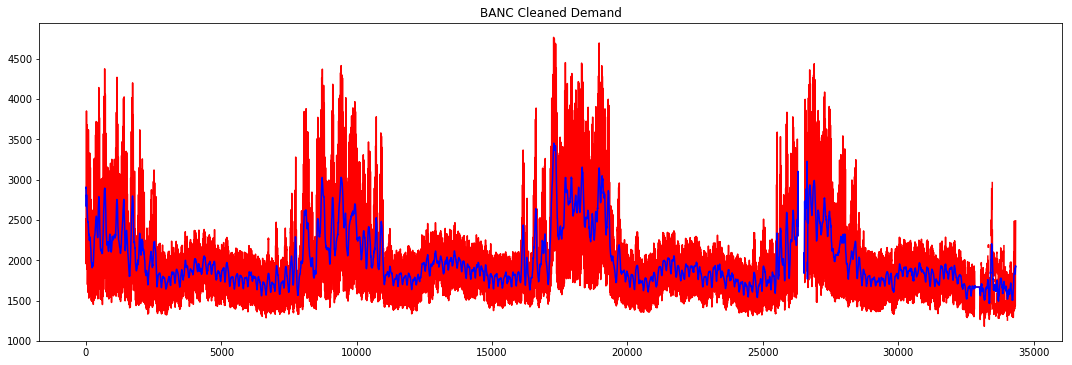

In [5]:
dem_map = {}
regions = ['TIDC', 'CISO', 'LDWP', 'BANC']
#regions = ['BANC',]# 'CISO', 'LDWP']
for region in regions:
#for region in return_all_regions():
    print(region)
    file_path = '../get_eia_demand_data/data/{}.csv'.format(region)
    dem_map[region] = pd.read_csv(file_path, #index_col='time',
                       dtype={'demand (MW)':np.float64},
                      parse_dates=True, na_values=['MISSING', 'EMPTY'])
    
    # Convert date/time
    dem_map[region]['time'] = pd.to_datetime(dem_map[region]['time'])

    plt.close()
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(dem_map[region]['demand (MW)'], 'r-', label='demand')
    plt.tight_layout()
    plt.title("{} Raw Demand".format(region))
    plt.savefig('plt/{}_demand_initial.png'.format(region))
    
    # Make missing and empty values
    dem_map[region] = dem_map[region].assign(missing=dem_map[region]['demand (MW)'].isna())
    
    # Set all negative and zero values to NAN
    dem_map[region]['demand (MW)'] = dem_map[region]['demand (MW)'].mask(dem_map[region]['demand (MW)'] <= 0.)
    
    # Add deltas
    dem_map[region] = add_48hr_rolling_median(dem_map[region])
    dem_map[region] = add_48hr_rolling_iqr(dem_map[region])
    dem_map[region] = add_deltas(dem_map[region])
    
    # Calculate IQRs
    iqr, iq2, iq3 = get_iqrs(dem_map[region]['diff_pre'])
    n_iqr, n_iq2, n_iq3 = get_iqrs(dem_map[region]['diff_pre']/dem_map[region]['rolling48iqr'])
    dem_iqr, dem_iq2, dem_iq3 = get_iqrs(dem_map[region]['demand (MW)'])
    
    # Plots
    dem_multiplier = 10
    multiplier_double = 4
    multiplier_single = 6
    logX = True if region == 'BANC' else False
    make_norm_diff_plot(dem_map[region], n_iq2, n_iq3, multiplier_double, 'plt/{}_diffs_norm_original.png'.format(region))
    make_diff_plot(dem_map[region], iq2, iq3, multiplier_double, 'plt/{}_diffs_original.png'.format(region))
    make_dem_hist(dem_map[region], dem_iq2, dem_iq3, dem_multiplier, 'plt/{}_dem_original.png'.format(region), logX)

    
    print("iqr pre {:.2f} x 5 = {:.2f}".format(iqr, iqr*5))
    print('diff_pre 25% {:.2f}  75% {:.2f}'.format(np.percentile(dem_map[region]['diff_pre'].dropna(), 25),
                                                  np.percentile(dem_map[region]['diff_pre'].dropna(), 75)))
    

    dem_map[region] = filter_deltas(dem_map[region], iq2, iq3, iqr, multiplier_double, multiplier_single)
    # Plot results for demand hist
    dem_iq3 = np.percentile(dem_map[region]['demand (MW)'].dropna(), 75)
    dem_iq2 = np.percentile(dem_map[region]['demand (MW)'].dropna(), 25)
    make_dem_hist(dem_map[region], dem_iq2, dem_iq3, dem_multiplier, 
                  'plt/{}_dem_post-delta-filter.png'.format(region), logX)
    
    # Filter on extreme demand values
    dem_map[region] = filter_extrem_demand(dem_map[region], dem_iq2, dem_iq3, dem_multiplier)
    make_dem_hist(dem_map[region], dem_iq2, dem_iq3, dem_multiplier, 
                  'plt/{}_dem_post-ext-dem-filter.png'.format(region))
    
    # Add rolling 48 hr average
    dem_map[region] = add_48hr_rolling(dem_map[region])
    dem_map[region] = add_demand_delta_rolling(dem_map[region])
    make_delta_dem_hist(dem_map[region], 'plt/{}_dem_delta_rolling.png'.format(region))

    #print(dem_map[region].head())
    #print(dem_map[region].loc[1000:1005])

    plt.close()
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(dem_map[region]['demand (MW)'], 'r-', label='demand')
    ax.plot(dem_map[region]['rolling48'], 'b-', label='rolling 48hr')
    plt.tight_layout()
    plt.title("{} Cleaned Demand".format(region))
    plt.savefig('plt/{}_demand.png'.format(region))

In [ ]:
for remove in ['series_id', 'year', 'month', 'day', 
               'hour', 'demand (MW)', 'forecast demand (MW)',
               'time',
               'diff_pre', 'diff_post'
              ]:
    df = df.drop(remove, axis=1)
df.head()

In [ ]:
df.describe().round(2)

In [ ]:
df.isna().sum(axis=0)

In [ ]:
plt.imshow(~df.isna(), aspect='auto')
plt.xlabel("variables")
plt.ylabel("cases")
plt.gray()
plt.show()